In [ ]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

In [ ]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install colabgymrender==1.0.2

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  Preparing metadata (setup.py) ... done
  Created wheel for colabgymrender: filename=colabgymrender-1.0.2-py3-none-any.whl size=2425 sha256=4b3c38d6b7f97d4c0220f616905ed603da9a2872f01e4ebdd8a044240cb6d82d
  Stored in directory: /root/.cache/pip/wheels/54/1d/51/d65a99106096dd07e3be6f08d5d3c2dd5f26ac98f626e5efc9
Successfully built colabgymrender


In [ ]:
from colabgymrender.recorder import Recorder

  np.bool8: (False, True),

  from scipy.ndimage.filters import sobel



In [ ]:
# install dependencies
!apt install chromium-browser xvfb

  and should_run_async(code)



Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  apparmor libfontenc1 libfuse3-3 liblzo2-2 libudev1 libxfont2 libxkbfile1 snapd squashfs-tools
  systemd-hwe-hwdb udev x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils xserver-common
Suggested packages:
  apparmor-profiles-extra apparmor-utils fuse3 zenity | kdialog
The following NEW packages will be installed:
  apparmor chromium-browser libfontenc1 libfuse3-3 liblzo2-2 libxfont2 libxkbfile1 snapd
  squashfs-tools systemd-hwe-hwdb udev x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common xvfb
The following packages will be upgraded:
  libudev1
1 upgraded, 17 newly installed, 0 to remove and 44 not upgraded.
Need to get 36.2 MB of archives.
After this operation, 129 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 apparmor amd64 3.0.4-2ubuntu2.3 [595 kB]


In [ ]:
env = gym.make('MountainCar-v0')
env = Recorder(env, './video')
state = env.reset()
done = False
total_reward = 0.0

while not done:
    action = env.action_space.sample()
    next_state, reward, done, info = env.step(action)
    total_reward += reward
    state = next_state

print(total_reward)
env.play()

  deprecation(

  deprecation(

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(

  if not isinstance(terminated, (bool, np.bool8)):



-200.0
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4


Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [ ]:
total_reward

  and should_run_async(code)



-200.0

In [ ]:
# Hyperparameters
max_epsilon = 1.0
min_epsilon = 0.0001
max_num_steps = 180000
epsilon_decay_intervals = 5000
gamma = 0.99 # discount
alpha = 0.001 # learning rate

memory_size = 50000
min_replay_size = 1000
batch_size = 64 # 32

target_update_frequency = 500 # target network update frequency 1000 100 500



*   max_num_steps: Khi chạy với các tham số đã cho thì reward không có sự thay đổi. Nên em nghĩ tăng số lượng bước mà agent học để nó có thể khám phá được nhiều. Ban đầu là 50 000 sau đó em tăng lên 100 000 và không có thay đổi nên em thử điều chỉnh các tham số khác. Cuối cùng là 180 000
*   episode_decay_intervals: số lượng bước mà sau đó epsilon sẽ giảm, epsilon sẽ giảm max_num_steps / epsilon_decay_intervals lần. Em giảm từ 10 000 xuống còn 5 000 do em nghĩ khi tìm được một đường đến đích thì ít cần phải khám phá. Và giúp việc train hội tụ nhanh hơn. Tuy nhiên việc này sẽ làm agent bỏ qua nhưng giải pháp tốt hơn.
*   alpha:Để tăng tốc độ học từ những trường hợp mới của agent, em đã tăng từ 0.0001 thành 0.001. Sau khi chạy thì model có chạy vượt qua điểm reward thấp nhất và giảm dần. Nên em đã thử lại là 0.0001 nhưng khi chạy 100 000 steps thì reward vẫn không thay đổi
*   memory_size: Tăng số lượng memory để agent không bỏ lỡ những trường hợp quan trọng.
*   batch_size: từ 32 em tăng lên 64, điều này để model hội tụ nhanh hơn.
*   target_update_frequency:target network sẽ được cập nhật nhanh hơn. Tuy nhiên, nó sẽ dẫn đến overfitting và tăng chi phí tính toán.



In [ ]:
print(env.observation_space.shape)
print(env.action_space)

(2,)
Discrete(3)


In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, env):
        super(NeuralNetwork, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, env.action_space.n)
        )
        '''self.network = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 64),
            nn.Tanh(),
            nn.Linear(64, env.action_space.n)
        )'''

    def forward(self, state):
        return self.network(state)

    def choose_action(self, state):
        state = torch.tensor(state, dtype=torch.float32)
        q_values = self(state.unsqueeze(0)) # pytorch requires inputs in terms of batch
        best_action = torch.argmax(q_values, dim=1)[0]

        return best_action.detach().item()

Em đổi hàm activation thành relu bởi vì nó hội tụ nhanh hơn và tránh hiện tượng vanishing gradient (các weight không được cập nhật)
Xây dựng mạng neural gồm 2 lớp ẩn là 128 và 64. Tuy thay đổi nhưng chạy nhiều lần thì em thấy kết quả không thay đổi nhiều bằng việc thay đổi tham số.

In [ ]:
def fill_memory(env):
    memory = deque(maxlen=memory_size)
    state = env.reset()
    for _ in range(min_replay_size):
        action = env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        experience = (state, action, reward, done, next_state)
        memory.append(experience)
        state = next_state
        if done:
            env.reset()

    return memory

In [ ]:
def dqn_training(env, max_num_steps, max_epsilon, min_epsilon, num_epsilon_decay_intervals, gamma, lr):
    q_net = NeuralNetwork(env)
    target_net = NeuralNetwork(env)
    target_net.load_state_dict(q_net.state_dict())
    optimizer = torch.optim.Adam(q_net.parameters(), lr=lr)

    memory = fill_memory(env)
    reward_buffer = deque(maxlen=100) # Rewards of the previous 100 episodes
    reward_buffer = deque(maxlen=100)  # Rewards of the previous 100 episodes
    loss_buffer = deque(maxlen=100)  # Losses of the previous 100 steps

    reward_per_episode = 0.0
    state = env.reset()
    all_rewards = []
    all_loss =[]

    for step in range(max_num_steps):
        epsilon = np.interp(step, [0, num_epsilon_decay_intervals], [max_epsilon, min_epsilon])

        random_number = np.random.uniform(0,1)
        if random_number <= epsilon:
            action = env.action_space.sample()
        else:
            action = q_net.choose_action(state)

        next_state, reward, done, info = env.step(action)
        experience = (state, action, reward, done, next_state)
        memory.append(experience)
        reward_per_episode += reward

        state = next_state

        if done:
            state = env.reset()
            reward_buffer.append(reward_per_episode)
            all_rewards.append((step, reward_per_episode))
            reward_per_episode = 0.0


        # Take a batch of experiences from the memory
        experiences = random.sample(memory, batch_size)
        states = [ex[0] for ex in experiences]
        actions = [ex[1] for ex in experiences]
        rewards = [ex[2] for ex in experiences]
        dones = [ex[3] for ex in experiences]
        next_states = [ex[4] for ex in experiences]

        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(-1) # (batch_size,) --> (batch_size, 1)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(-1)
        dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(-1)
        next_states = torch.tensor(next_states, dtype=torch.float32)

        # Compute targets using the formulation sample = r + gamma * max q(s',a')
        target_q_values = target_net(next_states)
        max_target_q_values = target_q_values.max(dim=1, keepdim=True)[0]
        targets = rewards + gamma * (1-dones) * max_target_q_values

        # Compute loss
        q_values = q_net(states)

        action_q_values = torch.gather(input=q_values, dim=1, index=actions)
        loss = torch.nn.functional.mse_loss(action_q_values, targets)

        all_loss.append((step, loss.item()))
        loss_buffer.append(loss.item())

        # gradient descent for q-network
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update target network
        if (step+1) % target_update_frequency == 0:
            target_net.load_state_dict(q_net.state_dict())

        # print training results
        if (step+1) % 1000 == 0:
            average_reward = np.mean(reward_buffer)
            average_loss = np.mean(loss_buffer)
            print(f'Episode: {len(all_rewards)} Step: {step+1} Average reward: {average_reward} Average loss: {average_loss}')

    return all_rewards,all_loss, q_net

In [ ]:
all_rewards, all_loss, q_net = dqn_training(env, max_num_steps, max_epsilon, min_epsilon, epsilon_decay_intervals, gamma, lr=alpha)

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(

  states = torch.tensor(states, dtype=torch.float32)



Episode: 5 Step: 1000 Average reward: -200.0 Average loss: 0.004238430455229718
Episode: 10 Step: 2000 Average reward: -200.0 Average loss: 0.04564114132663235
Episode: 15 Step: 3000 Average reward: -200.0 Average loss: 0.10551494577230187
Episode: 20 Step: 4000 Average reward: -200.0 Average loss: 0.21612205925746822
Episode: 25 Step: 5000 Average reward: -200.0 Average loss: 0.3827440018753987
Episode: 30 Step: 6000 Average reward: -200.0 Average loss: 0.4133183762943372
Episode: 35 Step: 7000 Average reward: -200.0 Average loss: 0.7159514186787419
Episode: 40 Step: 8000 Average reward: -200.0 Average loss: 0.6959630124014802
Episode: 45 Step: 9000 Average reward: -200.0 Average loss: 1.2721105057932436
Episode: 50 Step: 10000 Average reward: -200.0 Average loss: 1.1582015837309882
Episode: 55 Step: 11000 Average reward: -200.0 Average loss: 1.3924785621929914
Episode: 60 Step: 12000 Average reward: -200.0 Average loss: 1.2495235733455048
Episode: 65 Step: 13000 Average reward: -200.

  and should_run_async(code)



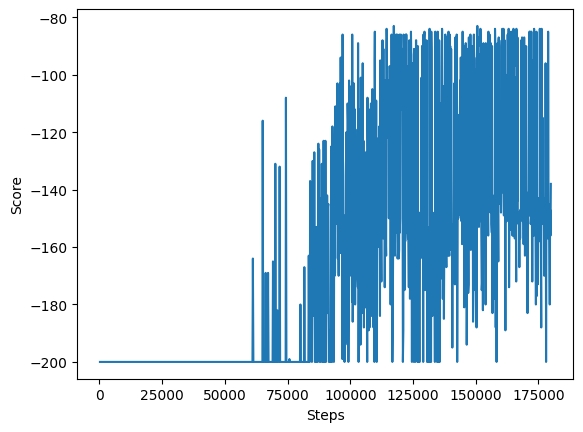

In [ ]:
all_rewards = np.array(all_rewards)
plt.xlabel('Steps')
plt.ylabel('Score')
plt.plot(all_rewards[:, 0], all_rewards[:, 1])

Từ 0 đến 25 000 step, agent không học được gì. Sau đó, số điểm thưởng tăng nhanh, nổi bật nhất trong khoảng 40 000. Việc này cho thấy rằng từ khoảng 40 000 steps, agent đã tìm được đường tới đỉnh.


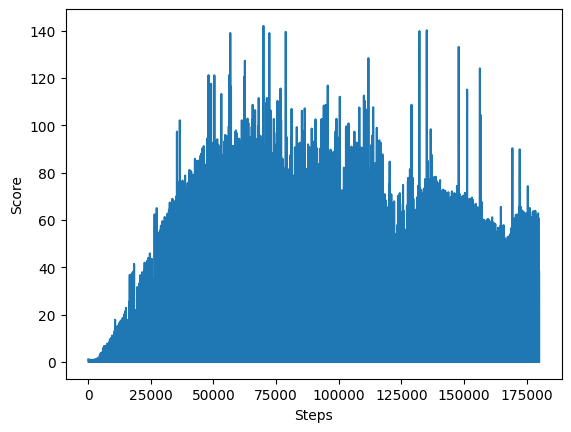

In [ ]:
all_loss = np.array(all_loss)
plt.xlabel('Steps')
plt.ylabel('Score')
plt.plot(all_loss[:, 0], all_loss[:, 1])

Khi step vào khoảng 140 000 thì giá trị hàm loss là nhỏ nhất. Sau đó tăng tới khoảng 70, và tương đối không đổi.

In [ ]:
env = Recorder(env, './video')
state = env.reset()
done = False
total_reward = 0.0
q_net.eval()

with torch.no_grad():
    while not done:
        #action = env.action_space.sample()
        action = q_net.choose_action(state)
        next_state, reward, done, info = env.step(action)
        total_reward += reward
        state = next_state

print(total_reward)
env.play()

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



-89.0
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4


Moviepy - Done !
Moviepy - video ready __temp__.mp4


Khi train có khi cùng với một model và tham số đó, nhưng kết quả lại khác nhau. <br>
Lần một được -112 <br>
Lần hai được -143 (agent không thể chạy tới đích) <br>
Lần ba được -83

In [39]:
class DuelingDQN(nn.Module):
    def __init__(self, env):
        super(DuelingDQN, self).__init__()
        self.num_actions = env.action_space.n
        self.feature_extraction = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        self.advantage = nn.Sequential(
            nn.Linear(64, self.num_actions)
        )
        self.value = nn.Sequential(
            nn.Linear(64, 1)
        )

    def forward(self, x):
        x = self.feature_extraction(x)
        advantage = self.advantage(x)
        value = self.value(x)
        return value + advantage - advantage.mean(dim=1, keepdim=True)

    def choose_action(self, state):
        state = torch.tensor(state, dtype=torch.float32)
        q_values = self(state.unsqueeze(0)) # pytorch requires inputs in terms of batch
        best_action = torch.argmax(q_values, dim=1)[0]

        return best_action.detach().item()

def dueling_dqn_training(env, max_num_steps, max_epsilon, min_epsilon, num_epsilon_decay_intervals, gamma, lr, batch_size, target_update_frequency):
    q_net = DuelingDQN(env)
    target_net = DuelingDQN(env)
    target_net.load_state_dict(q_net.state_dict())
    optimizer = optim.Adam(q_net.parameters(), lr=lr)

    memory = deque(maxlen=10000)  # Fixed size replay memory
    reward_buffer = deque(maxlen=100)  # Rewards of the previous 100 episodes
    loss_buffer = deque(maxlen=100)  # Losses of the previous 100 steps

    reward_per_episode = 0.0
    state = env.reset()
    all_rewards = []
    all_loss = []

    for step in range(max_num_steps):
        epsilon = np.interp(step, [0, num_epsilon_decay_intervals], [max_epsilon, min_epsilon])

        random_number = np.random.uniform(0, 1)
        if random_number <= epsilon:
            action = env.action_space.sample()
        else:
            with torch.no_grad():
                q_values = q_net(torch.tensor(state, dtype=torch.float32).unsqueeze(0))
                action = q_values.argmax().item()

        next_state, reward, done, info = env.step(action)
        experience = (state, action, reward, done, next_state)
        memory.append(experience)
        reward_per_episode += reward

        state = next_state

        if done:
            state = env.reset()
            reward_buffer.append(reward_per_episode)
            all_rewards.append((step, reward_per_episode))
            reward_per_episode = 0.0

        if len(memory) >= batch_size:
            # Take a batch of experiences from the memory
            experiences = random.sample(memory, batch_size)
            states = torch.tensor([ex[0] for ex in experiences], dtype=torch.float32)
            actions = torch.tensor([ex[1] for ex in experiences], dtype=torch.int64).unsqueeze(-1)  # (batch_size,) --> (batch_size, 1)
            rewards = torch.tensor([ex[2] for ex in experiences], dtype=torch.float32).unsqueeze(-1)
            dones = torch.tensor([ex[3] for ex in experiences], dtype=torch.float32).unsqueeze(-1)
            next_states = torch.tensor([ex[4] for ex in experiences], dtype=torch.float32)

            # Compute targets using the formulation sample = r + gamma * max q(s',a')
            with torch.no_grad():
                target_q_values = target_net(next_states)
                max_target_q_values = target_q_values.max(dim=1, keepdim=True)[0]
                targets = rewards + gamma * (1 - dones) * max_target_q_values

            # Compute loss
            q_values = q_net(states)
            action_q_values = torch.gather(input=q_values, dim=1, index=actions)
            loss = nn.functional.mse_loss(action_q_values, targets)

            all_loss.append((step, loss.item()))
            loss_buffer.append(loss.item())

            # Gradient descent for q-network
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Update target network
        if (step + 1) % target_update_frequency == 0:
            target_net.load_state_dict(q_net.state_dict())

        # Print training results
        if (step + 1) % 1000 == 0:
            average_reward = np.mean(reward_buffer)
            average_loss = np.mean(loss_buffer)
            print(f'Step: {step + 1} Average reward: {average_reward:.2f} Average loss: {average_loss:.4f}')

    return all_rewards, all_loss, q_net

Em nhờ chatgpt để code thuật toán dueling DQN. <br>
- Khi thiết kế mạng neural cho dueling DQN, sau khi qua các lớp để lấy các feature thì nó chia thành 2 phần nữa, một là value (để tính giá trị reward kì vọng nhận được từ trạng thái hiện tại) và advantages (sự khác biệt về giá trị của mỗi hành động với hành động tốt nhất, điều này giúp mạng tập trung vào những hành động tốt nhất cho mỗi giai đoạn)
- Dueling DQN được biết là sẽ ổn định và hoạt động tốt hơn DQN

In [40]:
all_rewards_dueling, all_loss_dueling, q_net_dueling = dueling_dqn_training(env, max_num_steps, max_epsilon, min_epsilon, epsilon_decay_intervals, gamma, lr=alpha,batch_size=batch_size,
    target_update_frequency=target_update_frequency)

Step: 1000 Average reward: -200.00 Average loss: 0.0023
Step: 2000 Average reward: -200.00 Average loss: 0.0371
Step: 3000 Average reward: -200.00 Average loss: 0.0865
Step: 4000 Average reward: -200.00 Average loss: 0.1475
Step: 5000 Average reward: -200.00 Average loss: 0.3160
Step: 6000 Average reward: -200.00 Average loss: 0.5273
Step: 7000 Average reward: -200.00 Average loss: 0.6448
Step: 8000 Average reward: -200.00 Average loss: 0.6344
Step: 9000 Average reward: -200.00 Average loss: 0.9870
Step: 10000 Average reward: -200.00 Average loss: 0.8549
Step: 11000 Average reward: -200.00 Average loss: 1.8433
Step: 12000 Average reward: -200.00 Average loss: 1.7768
Step: 13000 Average reward: -200.00 Average loss: 1.8875
Step: 14000 Average reward: -200.00 Average loss: 2.1813
Step: 15000 Average reward: -200.00 Average loss: 1.9653
Step: 16000 Average reward: -200.00 Average loss: 2.2714
Step: 17000 Average reward: -200.00 Average loss: 1.9619
Step: 18000 Average reward: -200.00 Aver

In [42]:
env = Recorder(env, './video')
state = env.reset()
done = False
total_reward = 0.0
q_net.eval()

with torch.no_grad():
    while not done:
        #action = env.action_space.sample()
        action = q_net_dueling.choose_action(state)
        next_state, reward, done, info = env.step(action)
        total_reward += reward
        state = next_state

print(total_reward)
env.play()

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



-139.0
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4


t:  95%|█████████▌| 134/141 [00:00<00:00, 338.20it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file ./video/1717754643.2527993.mp4, 720000 bytes wanted but 0 bytes read,at frame 140/141, at time 4.67/4.67 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+

                                                               

Moviepy - Done !
Moviepy - video ready __temp__.mp4


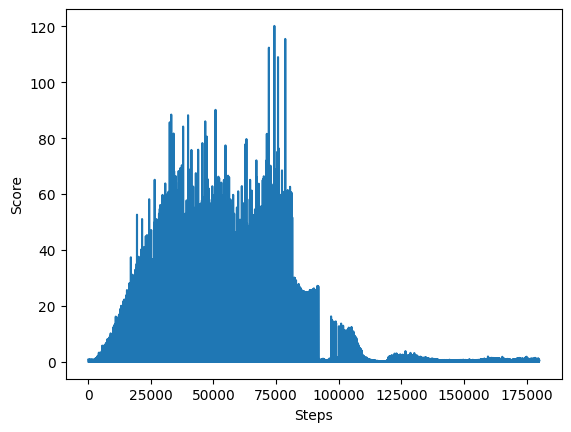

In [43]:
all_loss_dueling = np.array(all_loss_dueling)
plt.xlabel('Steps')
plt.ylabel('Score')
plt.plot(all_loss_dueling[:, 0], all_loss_dueling[:, 1])

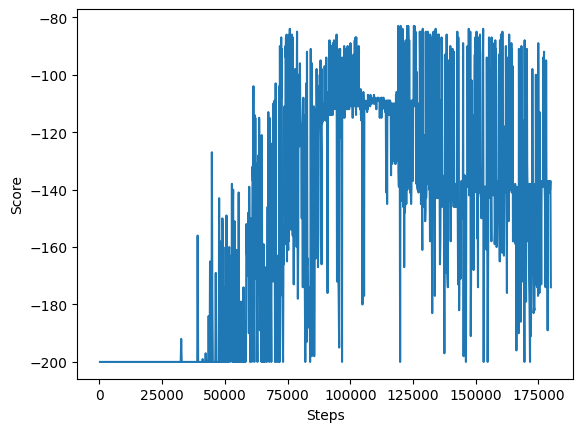

In [44]:
all_rewards_dueling = np.array(all_rewards_dueling)
plt.xlabel('Steps')
plt.ylabel('Score')
plt.plot(all_rewards_dueling[:, 0], all_rewards_dueling[:, 1])

In [33]:
class PrioritizedReplayBuffer:
    def __init__(self, capacity, alpha=0.6):
        self.capacity = capacity
        self.alpha = alpha
        self.buffer = deque(maxlen=capacity)
        self.priorities = np.zeros((capacity,), dtype=np.float32)
        self.pos = 0

    def add(self, experience, td_error):
        max_prio = self.priorities.max() if self.buffer else 1.0
        if len(self.buffer) < self.capacity:
            self.buffer.append(experience)
        else:
            self.buffer[self.pos] = experience

        self.priorities[self.pos] = max_prio
        self.pos = (self.pos + 1) % self.capacity

    def sample(self, batch_size, beta=0.4):
        if len(self.buffer) == self.capacity:
            prios = self.priorities
        else:
            prios = self.priorities[:self.pos]

        prios = prios ** self.alpha
        probs = prios / prios.sum()

        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[idx] for idx in indices]

        total = len(self.buffer)
        weights = (total * probs[indices]) ** (-beta)
        weights /= weights.max()

        batch = list(zip(*samples))

        states = torch.tensor(batch[0], dtype=torch.float32)
        actions = torch.tensor(batch[1], dtype=torch.int64).unsqueeze(-1)
        rewards = torch.tensor(batch[2], dtype=torch.float32).unsqueeze(-1)
        dones = torch.tensor(batch[3], dtype=torch.float32).unsqueeze(-1)
        next_states = torch.tensor(batch[4], dtype=torch.float32)

        return states, actions, rewards, dones, next_states, indices, torch.tensor(weights, dtype=torch.float32)

    def update_priorities(self, batch_indices, batch_priorities):
        for idx, prio in zip(batch_indices, batch_priorities):
            self.priorities[idx] = prio

def dqn_training_priority(env, max_num_steps, max_epsilon, min_epsilon, num_epsilon_decay_intervals, gamma, lr, batch_size, target_update_frequency):
    q_net = NeuralNetwork(env)
    target_net = NeuralNetwork(env)
    target_net.load_state_dict(q_net.state_dict())
    optimizer = optim.Adam(q_net.parameters(), lr=lr)

    memory = PrioritizedReplayBuffer(capacity=100000)
    reward_buffer = deque(maxlen=100)  # Rewards of the previous 100 episodes
    loss_buffer = deque(maxlen=100)  # Losses of the previous 100 steps

    reward_per_episode = 0.0
    state = env.reset()
    all_rewards = []
    all_loss = []

    for step in range(max_num_steps):
        epsilon = np.interp(step, [0, num_epsilon_decay_intervals], [max_epsilon, min_epsilon])

        random_number = np.random.uniform(0, 1)
        if random_number <= epsilon:
            action = env.action_space.sample()
        else:
            with torch.no_grad():
                q_values = q_net(torch.tensor(state, dtype=torch.float32).unsqueeze(0))
                action = q_values.argmax().item()

        next_state, reward, done, _ = env.step(action)
        with torch.no_grad():
            td_error = reward + gamma * np.max(target_net(torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)).numpy()) - q_net(torch.tensor(state, dtype=torch.float32).unsqueeze(0)).detach().numpy()[0, action]
        memory.add((state, action, reward, done, next_state), abs(td_error))
        reward_per_episode += reward

        state = next_state

        if done:
            state = env.reset()
            reward_buffer.append(reward_per_episode)
            all_rewards.append((step, reward_per_episode))
            reward_per_episode = 0.0

        if len(memory.buffer) >= batch_size:
            states, actions, rewards, dones, next_states, indices, weights = memory.sample(batch_size, beta=0.4)

            # Compute targets using the formulation sample = r + gamma * max q(s',a')
            with torch.no_grad():
                target_q_values = target_net(next_states)
                max_target_q_values = target_q_values.max(dim=1, keepdim=True)[0]
                targets = rewards + gamma * (1 - dones) * max_target_q_values

            # Compute loss
            q_values = q_net(states)
            action_q_values = torch.gather(input=q_values, dim=1, index=actions)
            loss = (weights * torch.nn.functional.mse_loss(action_q_values, targets, reduction='none')).mean()

            all_loss.append((step, loss.item()))
            loss_buffer.append(loss.item())

            # Gradient descent for q-network
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update priorities
            new_priorities = (targets - action_q_values).detach().abs().cpu().numpy() + 1e-6  # Small epsilon to avoid zero priority
            memory.update_priorities(indices, new_priorities)

        # Update target network
        if (step + 1) % target_update_frequency == 0:
            target_net.load_state_dict(q_net.state_dict())

        # Print training results
        if (step + 1) % 1000 == 0:
            average_reward = np.mean(reward_buffer)
            average_loss = np.mean(loss_buffer)
            print(f'Step: {step + 1} Average reward: {average_reward:.2f} Average loss: {average_loss:.4f}')

    return all_rewards, all_loss, q_net





Ưu tiên theo các trạng thái có TD error nhỏ hơn

In [34]:
all_rewards_priority, all_loss_priority, q_net_priority = dqn_training_priority(env, max_num_steps, max_epsilon, min_epsilon, epsilon_decay_intervals, gamma, lr=alpha,batch_size=batch_size,
    target_update_frequency=target_update_frequency)


  self.priorities[idx] = prio



Step: 1000 Average reward: -200.00 Average loss: 0.0135
Step: 2000 Average reward: -200.00 Average loss: 0.1266
Step: 3000 Average reward: -200.00 Average loss: 0.3001
Step: 4000 Average reward: -200.00 Average loss: 0.5434
Step: 5000 Average reward: -200.00 Average loss: 0.8002
Step: 6000 Average reward: -200.00 Average loss: 1.1254
Step: 7000 Average reward: -200.00 Average loss: 1.3244
Step: 8000 Average reward: -200.00 Average loss: 1.7741
Step: 9000 Average reward: -200.00 Average loss: 2.1145
Step: 10000 Average reward: -200.00 Average loss: 2.6434
Step: 11000 Average reward: -200.00 Average loss: 2.7906
Step: 12000 Average reward: -200.00 Average loss: 2.9367
Step: 13000 Average reward: -200.00 Average loss: 3.1245
Step: 14000 Average reward: -200.00 Average loss: 4.3702
Step: 15000 Average reward: -200.00 Average loss: 3.7241
Step: 16000 Average reward: -200.00 Average loss: 3.6047
Step: 17000 Average reward: -200.00 Average loss: 4.9682
Step: 18000 Average reward: -200.00 Aver

In [37]:
env = Recorder(env, './video')
state = env.reset()
done = False
total_reward = 0.0
q_net.eval()

with torch.no_grad():
    while not done:
        #action = env.action_space.sample()
        action = q_net_priority.choose_action(state)
        next_state, reward, done, info = env.step(action)
        total_reward += reward
        state = next_state

print(total_reward)
env.play()

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



-154.0
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4


t:  85%|████████▌ | 133/156 [00:00<00:00, 280.21it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file ./video/1717748129.9028647.mp4, 720000 bytes wanted but 0 bytes read,at frame 155/156, at time 5.17/5.17 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+

                                                               

Moviepy - Done !
Moviepy - video ready __temp__.mp4


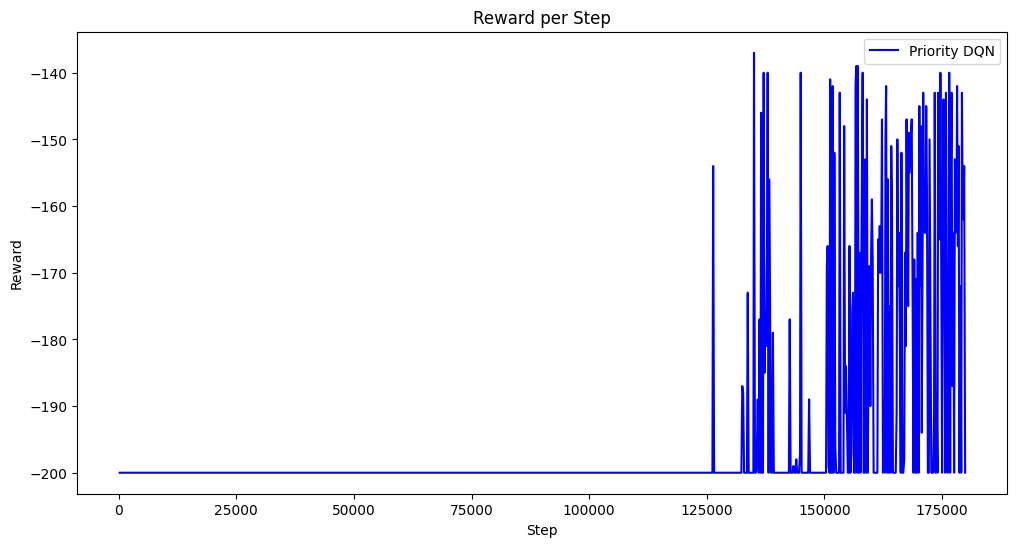

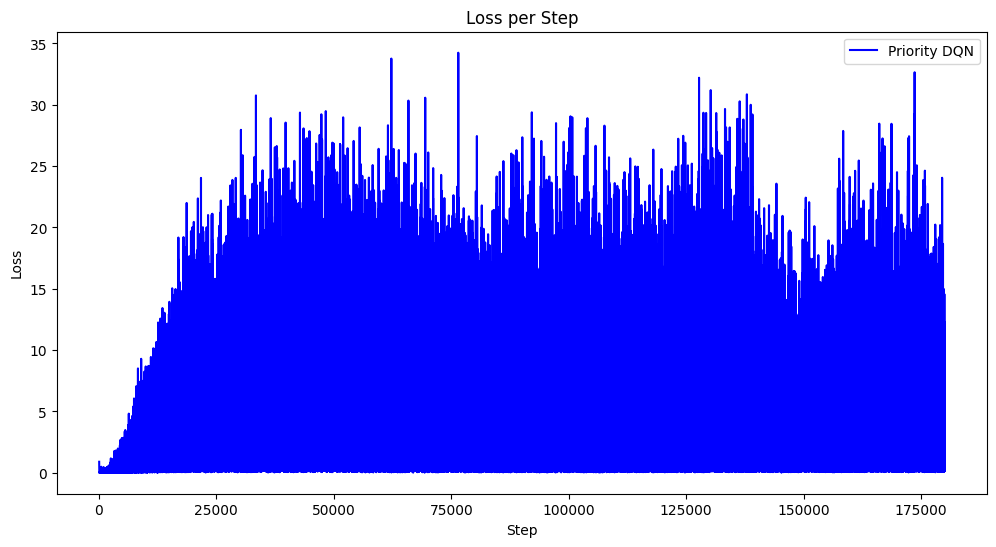

In [35]:
# Convert lists of tuples to NumPy arrays
all_rewards_priority = np.array(all_rewards_priority)
all_loss_priority = np.array(all_loss_priority)

# Plot rewards
plt.figure(figsize=(12, 6))
plt.plot(all_rewards_priority[:, 0], all_rewards_priority[:, 1], color='blue', label='Priority DQN')
plt.xlabel('Step')
plt.ylabel('Reward')
plt.title('Reward per Step')
plt.legend()
plt.show()

# Plot loss
plt.figure(figsize=(12, 6))
plt.plot(all_loss_priority[:, 0], all_loss_priority[:, 1], color='blue', label='Priority DQN')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Loss per Step')
plt.legend()
plt.show()

In [36]:
all_rewards_dueling = np.array(all_rewards_dueling)

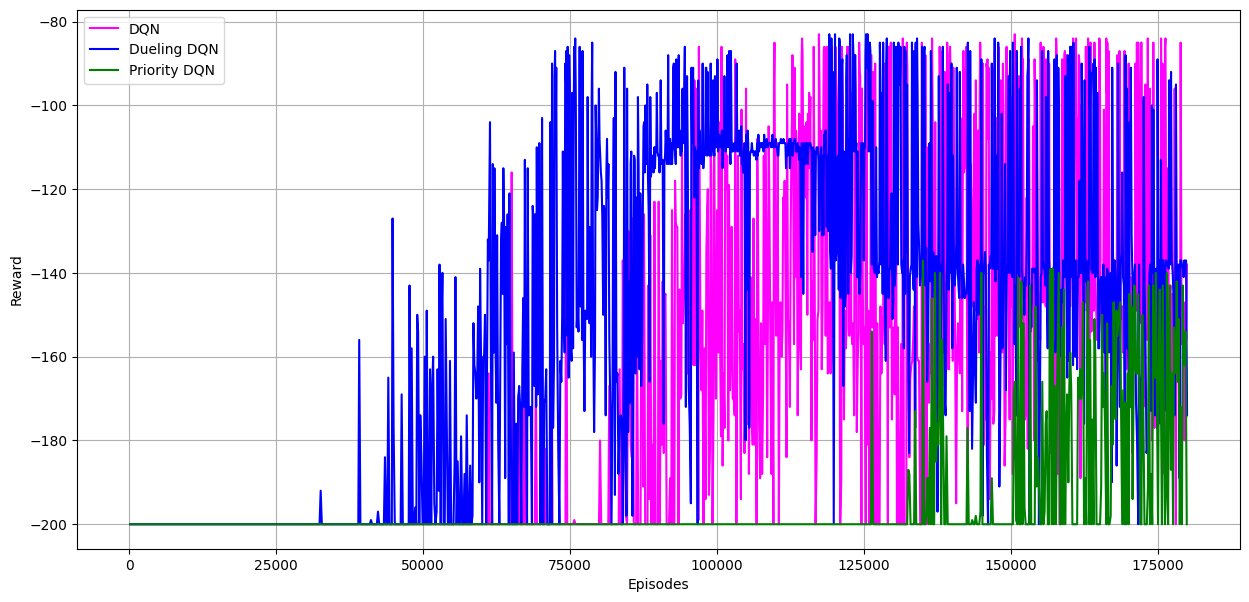

In [45]:
plt.figure(figsize=(15, 7))
plt.plot(all_rewards[:,0], all_rewards[:,1] , color='magenta', label='DQN')
plt.plot(all_rewards_dueling[:,0],all_rewards_dueling[:,1], color='blue', label='Dueling DQN')
plt.plot(all_rewards_priority[:,0],all_rewards_priority[:,1], color='green', label='Priority DQN')
plt.grid()
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.legend()
plt.show()

- Priority DQN tìm kiếm giải pháp và hội tụ lâu hơn hai thuật toán còn lại.
- Dueling DQN học nhanh hơn DQN vì từ 50 000 steps reward đã tăng.